In [1]:
from os import listdir
from collections import defaultdict
from math import comb, ceil

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

sns.set()
sns.set_palette("bright")
sns.set_style("whitegrid")

# RUN DATA

## AMD:

Model name:          AMD EPYC 7452 32-Core Processor

Kernel: 4.18.0-372.9.1.el8.x86_64

## Intel:

Model name:          Intel(R) Xeon(R) CPU E7-8890 v4 @ 2.20GHz

Kernel: 4.18.0-348.2.1.el8_5.x86_64

In [28]:
for m in ["amd/", "intel/", ""]:
    di = f"res/{m}"
    checksums = {}
    for fn in listdir(di):
        if "txt" not in fn:
            continue
        acc = 0
        ran = 0
        sel = 0
        with open(di + fn) as inf:
            for l in inf:
                if "access_check" in l:
                    acc = int(l.split()[-1])
                elif "rank_check" in l:
                    ran = int(l.split()[-1])
                elif "select_check" in l:
                    sel = int(l.split()[-1])
        ds = fn.split('_')[-1]
        if ds not in checksums:
            checksums[ds] = [(fn, acc, ran, sel)]
        else:
            checksums[ds].append((fn, acc, ran, sel))
    print(m, ":")
    for ds, tups in checksums.items():
        print("======", ds, "=======")
        acc = defaultdict(int)
        ran = defaultdict(int)
        sel = defaultdict(int)
        for t in tups:
            acc[t[1]] += 1
            ran[t[2]] += 1
            if "HYB" not in t[0]:
                sel[t[3]] += 1
        acc_c = sorted(acc.items(), key=lambda x: -x[1])[0][0]
        ran_c = sorted(ran.items(), key=lambda x: -x[1])[0][0]
        sel_c = sorted(sel.items(), key=lambda x: -x[1])[0][0]
        print(acc_c, ran_c, sel_c)
        for t in tups:
            if t[1] != acc_c:
                print(t)
                continue
            if t[2] != ran_c:
                print(t)
                continue
            if "HYB" not in t[0] and t[3] != sel_c:
                print(t)

amd/ :
====== rnd-50.16MB.txt =======
4993939 335600574756625 671349745601225
('HYBRRR_256_32_rnd-50.16MB.txt', 4993570, 335600576641746, 335600576641746)
====== bv-dump.bin.txt =======
2503280 10455494743730396 40748480512100248
('HYBRRR_256_32_bv-dump.bin.txt', 2491100, 10455494726011306, 10455494726011306)
====== WT-DNA-1GB.txt =======
5828270 22782127594449568 43290239141063738
('HYBRRR_256_32_WT-DNA-1GB.txt', 5826645, 22782127590998922, 22782127590998922)
====== WT-WEB-1GB.txt =======
5288645 23338635564356618 42481085257560706
('HYBRRR_256_32_WT-WEB-1GB.txt', 5288026, 23338635551616740, 23338635551616740)
intel/ :
====== rnd-50.16MB.txt =======
4993939 335600574756625 671349745601225
('HYBRRR_256_32_rnd-50.16MB.txt', 4993570, 335600576641746, 335600576641746)
====== bv-dump.bin.txt =======
2503280 10455494743730396 40748480512100248
('HYBRRR_256_32_bv-dump.bin.txt', 2491100, 10455494726011306, 10455494726011306)
====== WT-DNA-1GB.txt =======
5828270 22782127594449568 432902391410

In [29]:
stuff = []
for machine in ["amd/", "intel/", ""]:
    di = f"res/{machine}"
    for fn in listdir(di):
        if "txt" not in fn:
            continue
        d = {}
        with open(di + fn) as inf:
            for l in inf:
                if "access_time" in l:
                    d["access"] = float(l.split()[-1])
                elif "plain_size" in l:
                    d["elems"] = float(l.split()[-1])
                elif "rank_time" in l:
                    d["rank"] = float(l.split()[-1])
                elif "select_time" in l and "HYB" not in fn:
                    d["select"] = float(l.split()[-1])
                elif "rrr_size" in l:
                    d["size_bytes"] = float(l.split()[-1])
        fn_arr = fn.split('_')
        d["data_set"] = fn_arr[-1]
        d["type"] = fn_arr[0]
        d["block_size"] = fn_arr[1]
        if "GAP" in fn:
            d["gap_size"] = fn_arr[3]
        d["OPT"] = False if "NOOPT" in fn else True
        d["machine"] = machine if machine else "laptop"
        if d["type"] == "SDSL" and d["block_size"] == "256":
            continue
        stuff.append(d)

df = pd.DataFrame.from_dict(stuff)

In [26]:
testset = "laptop"

In [5]:
files = ['WT-DNA-1GB.txt', 'WT-WEB-1GB.txt', 'bv-dump.bin.txt', 'rnd-50.16MB.txt']

In [6]:
def gap_bytes(b, g):
    acc = 0
    types = (b + 1) // 2;
    for i in range(types + 1):
        acc += (comb(b, i) + g - 1) / g;
    return (acc * b + 7) / 8;

def deBrujin_bytes(b):    rnd-50.16MB
    WT-DNA-1GB
    WT-WEB-1GB
    acc = b;
    for i in range(1, (b + 1) // 2 + 1):
        acc += comb(b, i) + 1
    return (acc + 7) / 8

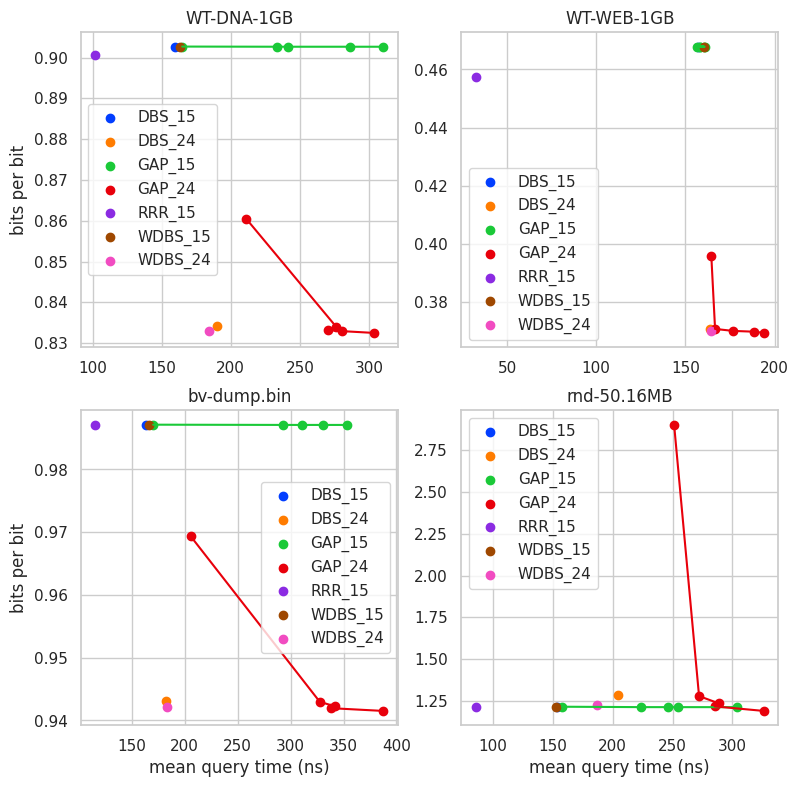

In [30]:
sdf = df[df["machine"] == testset]
sdf = sdf[sdf["type"].isin(["H0GAP", "RRR", "H0WDBS", "H0DBS"])]
plt.figure(figsize=(9, 9))
for i, dat in enumerate(files):
    plt.subplot(2, 2, i + 1)
    ddf = sdf[sdf["data_set"] == dat]
    parts = []
    tdf = ddf[ddf["type"] == "H0GAP"]
    tdf = tdf[tdf["block_size"] == "15"]
    sdat = sorted([
        (g, t, (s + gap_bytes(15, int(g))) / e) 
        for g, t, s, e 
        in zip(tdf["gap_size"], tdf["access"], tdf["size_bytes"], tdf["elems"])
    ])
    parts.append(("GAP_15", [t[1] for t in sdat], [t[2] for t in sdat]))

    tdf = ddf[ddf["type"] == "H0GAP"]
    tdf = tdf[tdf["block_size"] == "24"]
    sdat = sorted([
        (g, t, (s + gap_bytes(24, int(g))) / e) 
        for g, t, s, e 
        in zip(tdf["gap_size"], tdf["access"], tdf["size_bytes"], tdf["elems"])
    ])
    parts.append(("GAP_24", [t[1] for t in sdat], [t[2] for t in sdat]))

    tdf = ddf[ddf["type"] == "H0WDBS"]
    for a, s, e, t, b in zip(tdf["access"], tdf["size_bytes"], tdf["elems"], tdf["type"], tdf["block_size"]):
        parts.append((f"{t[2:]}_{b}", [a],  [(s + ((2**(int(b) - 1) + int(b)) / 8)) / e]))

    tdf = ddf[ddf["type"] == "H0DBS"]
    for a, s, e, t, b in zip(tdf["access"], tdf["size_bytes"], tdf["elems"], tdf["type"], tdf["block_size"]):
        parts.append((f"{t[2:]}_{b}", [a],  [(s + ((2**int(b) + int(b)) / 8)) / e]))

    tdf = ddf[ddf["type"] == "RRR"]
    for a, s, e, t, b in zip(tdf["access"], tdf["size_bytes"], tdf["elems"], tdf["type"], tdf["block_size"]):
        parts.append((f"{t}_{b}", [a],  [(s + (2**int(b) * 15 / 8)) / e]))

    parts.sort()

    for k, (l, a, s) in zip(sns.color_palette(), parts):
        plt.scatter(a, s, color=k, label=l)
        if len(a) > 1:
            plt.plot(a, s, color=k)
    if i % 2 == 0:
        plt.ylabel("bits per bit")
    if i >= 2:
        plt.xlabel("mean query time (ns)")
    plt.legend()
    plt.title(dat[:-4])

plt.savefig(f"lookup_tables_{testset}.pdf", bbox_inches='tight')
plt.show()


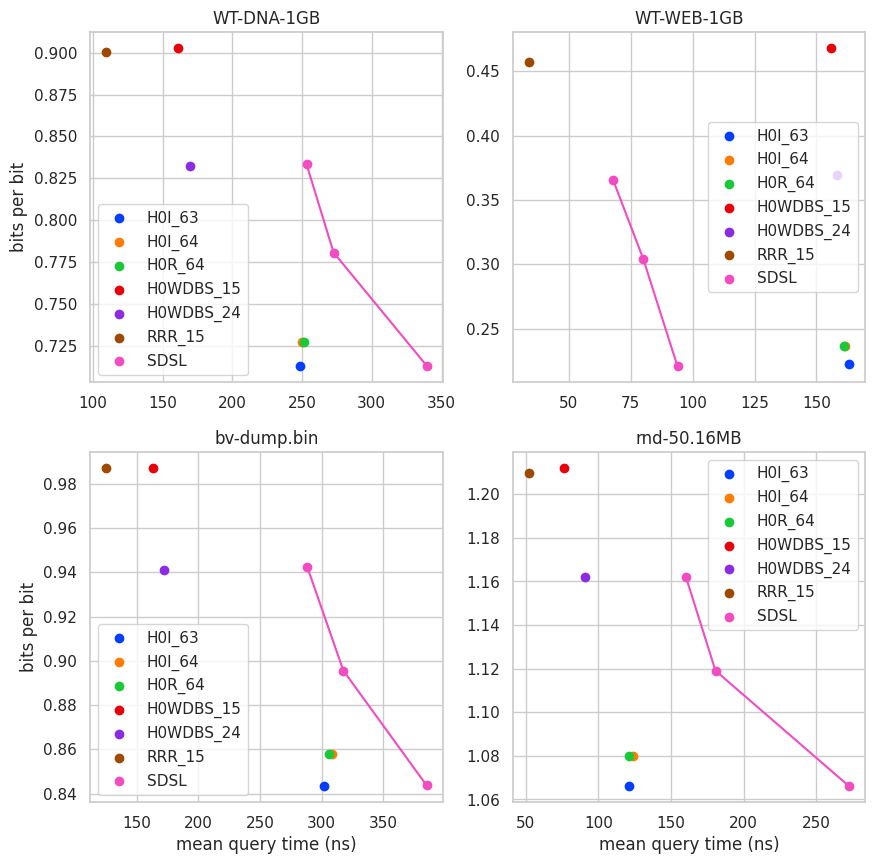

In [12]:
sdf = df[df["machine"] == testset]
sdf = sdf[sdf["type"].isin(['H0I', 'H0R', 'H0WDBS', 'RRR', 'SDSL'])]
plt.figure(figsize=(10, 10))
for i, dat in enumerate(files):
    plt.subplot(2, 2, i + 1)
    ddf = sdf[sdf["data_set"] == dat]
    pats = []
    tdf = ddf[ddf["type"] == "SDSL"]
    tdf = tdf[tdf["OPT"] == True]
    sdat = sorted([(b, a, s / e) for a, s, e, b in zip(tdf["access"], tdf["size_bytes"], tdf["elems"], tdf["block_size"])])[1:]
    pats.append(("SDSL", [t[1] for t in sdat], [t[2] for t in sdat]))
    tdf = ddf[ddf["type"].isin(['H0I', 'H0R', 'H0WDBS', 'RRR'])]
    for a, s, e, t, b, o in zip(tdf["access"], tdf["size_bytes"], tdf["elems"], tdf["type"], tdf["block_size"], tdf["OPT"]):
        if o == False:
            continue
        pats.append((f"{t}_{b}", [a], [s / e]))

    pats.sort()
    for c, t in zip(sns.color_palette(), pats):
        plt.scatter(t[1], t[2], color=c, label=t[0])
        if len(t[1]) > 1:
            plt.plot(t[1], t[2], color=c)
    if i % 2 == 0:
        plt.ylabel("bits per bit")
    if i >= 2:
        plt.xlabel("mean query time (ns)")
    plt.legend()
    plt.title(dat[:-4])
plt.savefig(f"overall_{testset}.pdf", bbox_inches='tight')
plt.show()

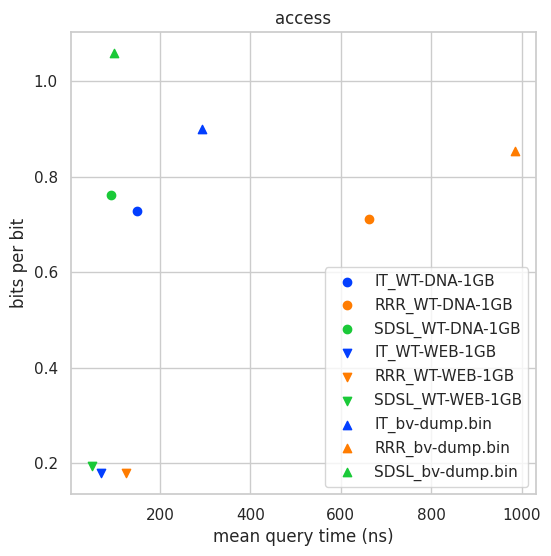

In [22]:
sdf = df[df["machine"] == testset]
sdf = sdf[sdf["type"].str.contains("HYB")]
plt.figure(figsize=(6, 6))
for m, dat in zip("ov^,", files):
    if "rnd" in dat:
        continue
    ddf = sdf[sdf["data_set"] == dat]
    dats = []
    for a, s, e, t, b in zip(ddf["access"], ddf["size_bytes"], ddf["elems"], ddf["type"], ddf["block_size"]):
        dats.append((f"{t}_{b}", [a], [s / e]))
    dats.sort()
    for c, t in zip(sns.color_palette(), dats):
        plt.scatter(t[1], t[2], color=c, marker=m, label=f"{t[0][3:-3]}{dat[:-4]}")
    plt.ylabel("bits per bit")
    plt.xlabel("mean query time (ns)")
    plt.legend()
    plt.title("access")
plt.savefig(f"hybrid_{testset}.pdf", bbox_inches='tight')
plt.show()

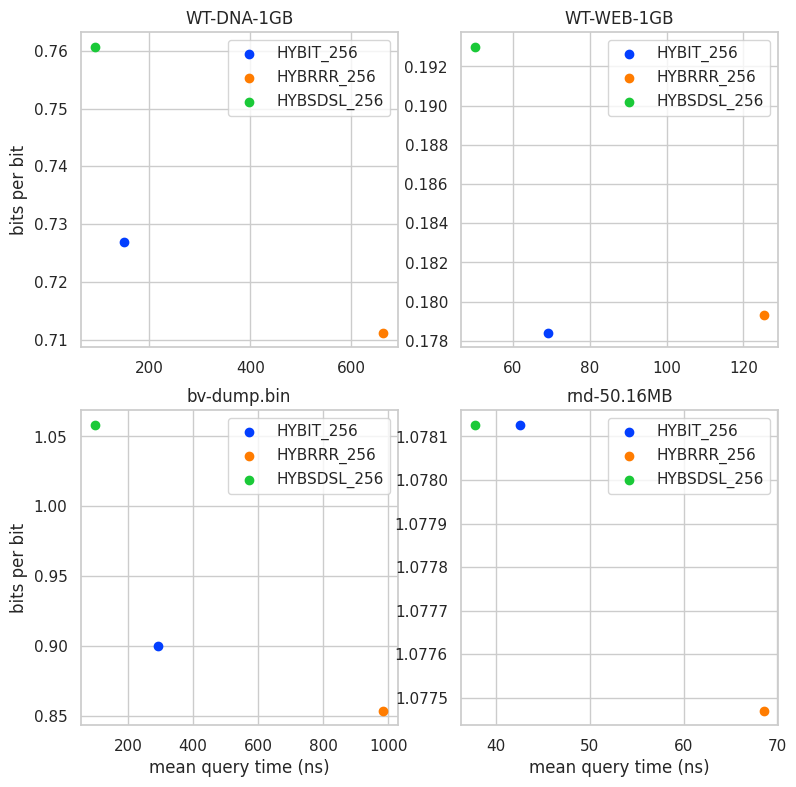

In [13]:
sdf = df[df["machine"] == testset]
sdf = sdf[sdf["type"].str.contains("HYB")]
plt.figure(figsize=(9, 9))
for i, dat in enumerate(files):
    plt.subplot(2, 2, i + 1)
    ddf = sdf[sdf["data_set"] == dat]
    dats = []
    for a, s, e, t, b in zip(ddf["access"], ddf["size_bytes"], ddf["elems"], ddf["type"], ddf["block_size"]):
        dats.append((f"{t}_{b}", [a], [s / e]))
    dats.sort()
    for c, t in zip(sns.color_palette(), dats):
        plt.scatter(t[1], t[2], color=c, label=t[0])
    if i % 2 == 0:
        plt.ylabel("bits per bit")
    if i >= 2:
        plt.xlabel("mean query time (ns)")
    plt.legend()
    plt.title(dat[:-4])
plt.savefig(f"hybrid_{testset}.pdf", bbox_inches='tight')
plt.show()